<a href="https://colab.research.google.com/github/erfunmirzaei/DOL-Project3/blob/main/Project3_DOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition

We implement Bandit learning algorithms for single-agent and multi-agent scenarios in this project. To this end, we used a non-stationary environment where some reward functions change disruptively.

 We consider different single-agent multi-armed bandits with 2 and 10 arms in the first part. In both cases, we design environments with different difficulty levels, i.e., discriminability of rewards. We use Epsilon-greedy, Upper-Confidence Bound(UCB), Policy-gradient, Thompson Sampling, and Actor-Critic algorithms in this part. 

In the second part, we consider multi-agent multi-armed bandit scenarios. Similar to the former, we consider different numbers of arms with different reward probability distributions. In this part, we use Joint Action Learners(JAL), Free Maximum Q-value(FMQ), Distributed Q-learning, and Multi-agent Actor-Critic Algorithm.  

In [ ]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import random
import gym
from scipy.stats import t
from statistics import mean
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementations

## Rewards

In [ ]:
class MultinomialReward_NonStationary():
    def __init__(self, rewards, probs, switch_t):
        self.rewards = rewards
        self.probs = probs
        self.switch_t = switch_t

    def get_reward(self, t):
        if t < self.switch_t:
            return random.choices(self.rewards, weights = self.probs, k = 1)[0]
        
        else:
            return random.choices(self.rewards[::-1], weights = self.probs, k = 1)[0]

In [ ]:
class MultinomialReward():
    def __init__(self, rewards, probs):
        self.rewards = rewards
        self.probs = probs

    def get_reward(self):
        return random.choices(self.rewards, weights = self.probs, k = 1)[0]

In [ ]:
class DeteriministicReward():
    def __init__(self, reward):
        self.reward = reward

    def get_reward(self):
        return self.reward

In [ ]:
class GaussianReward():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)

In [ ]:
class Students_t_distReward():
    def __init__(self,dof, mean, std):
        self.dof = dof
        self.mean = mean
        self.std = std

    def get_reward(self):
        return t.rvs(df = self.dof, loc=self.mean, scale=self.std)

## N-Armed Bandit Environments

In [ ]:
class MutliArmedBanditEnvironment():
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.state = None
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def register_agent(self, agent):
        if type(agent.id) != str:
            raise Exception('Agent id must be a valid string.')
        if agent.id in self.agents.keys():
            raise Exception('An agent with the same id already exists.')
        
        self.agents[agent.id] = agent
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self, action):
        return {} 

    def step(self, action):
        # err_msg = "%r (%s) invalid" % (action, type(action))
        # assert self.action_space.contains(action), err_msg

        reward = self.calculate_reward(action)
        info = self.get_info(action)
        self.next_state(action)
        done = self.terminated()
        observation = self.observe()
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [ ]:
class MutliAgent_MAB_Environment():
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arms_rewards = rewards # consits all rewards method
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def register_agent(self, agent):
        if type(agent.id) != str:
            raise Exception('Agent id must be a valid string.')
        if agent.id in self.agents.keys():
            raise Exception('An agent with the same id already exists.')
        
        self.agents[agent.id] = agent
        
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self, action):
        return {} 

    def step(self, actions):
        # err_msg = "%r (%s) invalid" % (action, type(action))
        # assert self.action_space.contains(action), err_msg
        rewards = []
        for a in actions:
            rewards.append(self.calculate_reward(a))    
        
        reward = sum(rewards) / len(rewards) #max(rewards) #Write Method
        info = self.get_info(actions)
        self.next_state(actions)
        done = self.terminated()
        observation = self.observe()
        return observation, reward, done, info

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

## Agents 

In [ ]:
from abc import ABC, abstractmethod

class AgentBase:
    def __init__(self, id, environment=None):
        self.id = id
        self.environment = environment

    def set_environment(self, env):
        self.environment = env

    @abstractmethod
    def take_action(self) -> (object, float, bool, object):
        # in this method, you MUST call the `step` method of 
        # the environment and observe the results and return them like:
        # return observation, reward, done, info
        pass

In [ ]:
import numpy as np
#Add Temperature

class EpsilonGreedyAgent(AgentBase): 
    def __init__(self, id, environment, epsilon = 0.1,epsilon_decay = 1,lr = None,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        available_actions = self.environment.available_actions()
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((available_actions,1))     #action value fuction
        self.N = np.zeros((available_actions,1))     #number of doing an action 

    def get_number_actions(self):
        return self.N

    def update(self,action,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        self.N[action] += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        rand = np.random.rand()
        if rand < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            action = np.argmax(self.Q)
        
        obs, r, d, i = self.environment.step(action)
        #print("*",r)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u

    def get_Q(self):
        return self.Q

In [ ]:
import numpy as np

class MultiAgentActorCritic(AgentBase): 
    def __init__(self, ids, environment, lr = 0.1,lr_decay = 1,nu = 0.1, nu_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(MultiAgentActorCritic, self).__init__(ids, environment)
        available_actions = self.environment.available_actions()
        self.available_actions = available_actions
        self.lr = lr
        self.lr_decay = lr_decay
        self.nu = nu 
        self.nu_decay = nu_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.ids = ids
        self.com_weight =(1/(len(ids))) * np.ones((len(ids),len(ids)))
        self.avg_rew = np.zeros((len(self.ids)))      
        self.Q = np.zeros((available_actions,len(self.ids)))     #action value fuction
        self.Q_tilde = np.zeros((available_actions,len(self.ids)))     #action value fuction
        self.H = np.zeros((available_actions,len(self.ids)))
        self.P = (1/available_actions)*np.ones((available_actions,len(self.ids)))

    def update(self,actions,utility):
        self.lr = self.lr * self.lr_decay
        self.nu = self.nu * self.nu_decay
        
        Buffer = []

        for i,a in enumerate(actions):
            self.avg_rew[i] += (utility - self.avg_rew[i]) * self.lr
            delta = utility - self.avg_rew[i]
            self.Q_tilde[a,i] = self.Q[a,i] + self.lr * delta

            A = self.Q[a,i]
            for j in range(self.available_actions):
                A = A - self.P[j,i] * self.Q[j,i]
            
            for j in range(self.available_actions):
                if j == a:
                    self.H[j,i] += self.nu *A*(1-self.P[j,i])

                else:
                    self.H[j,i] -=  self.nu *A*(self.P[j,i])
            
        for i in range(len(self.ids)):
            self.Q[:,i] = sum([self.com_weight[j,i] * self.Q_tilde[:,j] for j in range(len(self.ids))])

        for i in range(len(self.ids)):
            for j in range(self.available_actions):
                self.P[j,i] = np.exp(self.H[j,i]) / np.sum(np.exp(self.H[:,i]))

    def get_all(self):
        return self.H,self.P

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 


    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        actions = []
        for i in range(len(self.ids)):
            a = int(np.random.choice(list(range(available_actions)), size=1,p=self.P[:,i]))        
            actions.append(a)
        obs, r, d, i = self.environment.step(actions)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(actions,u)
        #self.environment.render()
        return r, actions , u


In [ ]:
import numpy as np
#Add Temperature

class JAL_Agents(AgentBase): 
    def __init__(self, ids, environment, epsilon = 0.1,epsilon_decay = 1,lr = None,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(JAL_Agents, self).__init__(ids, environment)
        available_actions = self.environment.available_actions()
        self.available_actions = available_actions
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.ids = ids
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((available_actions,len(ids)))     #action value fuction
        self.Q_tilde = np.zeros((available_actions,len(ids)))
        self.N = np.zeros((available_actions,len(ids)))     #number of doing an action 

    def get_number_actions(self):
        return self.N

    def bias_update(self):
        for i in range(len(self.ids)):
            for a in range(self.available_actions):
                sum = 0
                for b in range(self.available_actions):
                    p = 1
                    for j in range(len(self.ids)):
                        p = p * (self.N[b,j] / self.N[:,j].sum())
                    
                    sum += p * self.Q[a,i]
                
                self.Q_tilde[a,i] = sum
    
    def update(self,actions,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        for i,a in enumerate(actions):
            self.N[a,i] += 1
            if self.lr is not None:
                self.Q[a,i] += (utility - self.Q[a,i]) * self.lr
                self.Q_tilde[a,i] += (utility - self.Q_tilde[a,i]) * self.lr
                self.lr = self.lr * self.lr_decay 
            else:
                self.Q[a,i] += (utility - self.Q[a,i])/self.N[a,i] 
                self.Q_tilde[a,i] += (utility - self.Q_tilde[a,i])/self.N[a,i] 

        self.bias_update()

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        rand = np.random.rand()
        actions = []
        for i in range(len(self.ids)):
            if rand < self.epsilon:
                a = np.random.choice(available_actions)
            else:
                a = np.argmax(self.Q_tilde[:,i])
            actions.append(a)

        obs, r, d, i = self.environment.step(actions)
        #print("*",r)
        u = self.utility_function(r)
        self.update(actions,u)
        #self.environment.render()
        return r, actions , u

    def get_Q(self):
        return self.Q

In [ ]:
import numpy as np
#Add Temperature

class Dis_Q_Agents(AgentBase): 
    def __init__(self, ids, environment, epsilon = 0.1,epsilon_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(Dis_Q_Agents, self).__init__(ids, environment)
        available_actions = self.environment.available_actions()
        self.available_actions = available_actions
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.ids = ids
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((available_actions,len(self.ids)))     #action value fuction
        self.N = np.zeros((available_actions,len(self.ids)))     #number of doing an action 
        self.greedy_actions = np.zeros((len(self.ids),1))

    def get_number_actions(self):
        return self.N
    
    def get_greedy_actions(self):
        return self.greedy_actions

    def update(self,actions,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        for i,a in enumerate(actions):
            self.N[a,i] += 1
            if utility > self.Q[a,i]:
                self.Q[a,i] = utility 
                
            if utility > max(self.Q[:,i]):
                self.greedy_actions[i,0] = a

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        rand = np.random.rand()
        actions = []
        for i in range(len(self.ids)):
            if rand < self.epsilon:
                a = np.random.choice(available_actions)
            else:
                a = int(self.greedy_actions[i])
            actions.append(a)

        obs, r, d, i = self.environment.step(actions)
        #print("*",r)
        u = self.utility_function(r)
        self.update(actions,u)
        #self.environment.render()
        return r, actions , u

    def get_Q(self):
        return self.Q

In [ ]:
import numpy as np
#Add Temperature

class FMQ_Agents(AgentBase): 
    def __init__(self, ids, environment, epsilon = 0.1,epsilon_decay = 1,lr = None,lr_decay = 1,nu = 0.1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(FMQ_Agents, self).__init__(ids, environment)
        available_actions = self.environment.available_actions()
        self.available_actions = available_actions
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.ids = ids
        self.lr = lr
        self.lr_decay = lr_decay
        self.nu = nu
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.Q = np.zeros((available_actions,len(ids)))     #action value fuction
        self.Q_tilde = np.zeros((available_actions,len(ids)))
        self.N = np.zeros((available_actions,len(ids)))     #number of doing an action 
        self.maxR = -100000000000 * np.ones((available_actions,len(ids)))
        self.N_maxR = np.zeros((available_actions,len(ids)))

    def get_number_actions(self):
        return self.N

    def bias_update(self):
        for i in range(len(self.ids)):
            for a in range(self.available_actions):
                self.Q_tilde[a,i] = self.Q[a,i] + (self.nu)*(self.N_maxR[a,i]/self.N[a,i])*self.maxR[a,i] 
        
    def update(self,actions,utility):
        self.epsilon = self.epsilon * self.epsilon_decay
        for i,a in enumerate(actions):
            self.N[a,i] += 1
            if utility > self.maxR[a,i]:
                self.maxR[a,i] = utility
                self.N_maxR[a,i] = 1
            elif utility == self.maxR[a,i]:
                self.N_maxR[a,i] += 1

            if self.lr is not None:
                self.Q[a,i] += (utility - self.Q[a,i]) * self.lr
                self.lr = self.lr * self.lr_decay 
            else:
                self.Q[a,i] += (utility - self.Q[a,i])/self.N[a,i] 

        self.bias_update()

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        rand = np.random.rand()
        actions = []
        for i in range(len(self.ids)):
            if rand < self.epsilon:
                a = np.random.choice(available_actions)
            else:
                a = np.argmax(self.Q_tilde[:,i])
            actions.append(a)

        obs, r, d, i = self.environment.step(actions)
        #print("*",r)
        u = self.utility_function(r)
        self.update(actions,u)
        #self.environment.render()
        return r, actions , u

    def get_Q(self):
        return self.Q

In [ ]:
import numpy as np

class UCBBanditAgent(AgentBase):
    def __init__(self, id, environment:MutliArmedBanditEnvironment, c,lr = None, pros_attrs={'alpha': 1, 'beta': 1, 'gama': 1}):
        super(UCBBanditAgent, self).__init__(id, environment)
        self.c = c
        self.lr = lr
        self.pros_attrs = pros_attrs
        self.utility_func = lambda r: -1*self.pros_attrs['gama']*abs(r)**self.pros_attrs['beta'] if r<0 else r**self.pros_attrs['alpha']
        # init
        self.Ns = [0 for _ in range(environment.available_actions())]
        self.Qs = [0 for _ in range(environment.available_actions())]

    def take_action(self) -> (object, float, bool, object):

        # choose action based on UCB
        t = self.environment.state['length']
        if np.any(np.array(self.Ns) == 0):
            # choose randomly among maximizing actions
            maximizing_actions = [i for i, j in enumerate(self.Ns) if j==0]
            action = np.random.choice(maximizing_actions)
        else:
            # calc upper confidence bounds
            standard_err = np.sqrt(np.log(t) / np.array(self.Ns))
            UCB = (np.array(self.Qs) + self.c*standard_err)
            # choose randomly among actions with largest UCB 
            max_ucb = max(UCB)
            greedy_actions = [i for i, j in enumerate(UCB) if j==max_ucb]
            action = np.random.choice(greedy_actions)

        obs, r, d, i = self.environment.step(action)
        u = self.utility_func(r)

        # update action values
        self.Ns[action] = self.Ns[action] + 1
        if self.lr is not None:
            self.Qs[action] = self.Qs[action] + self.lr*(u-self.Qs[action])
        else:
            self.Qs[action] = self.Qs[action] + self.Ns[action]**(-1)*(u-self.Qs[action])

        return r, action, u

In [ ]:
# import numpy as np
# from math import sqrt

# class UCBAgent(AgentBase):
#     def __init__(self, id, environment, exploration_degree = 2, lr = None, lr_decay = 1,alpha = 1,beta = 1,gamma = 1):
#         super(UCBAgent, self).__init__(id, environment)
#         available_actions = self.environment.available_actions()
#         self.lr = lr
#         self.lr_decay = lr_decay
#         self.alpha = alpha
#         self.beta = beta 
#         self.gamma = gamma
#         self.exp_deg = exploration_degree                        #hyperparameter
#         self.Q = np.zeros((available_actions,1))                 #action value fuction(expected reward) for each arm
#         self.N = np.zeros((available_actions,1))                 #number of doing each arm
#         self.trials = 0                                          #number of total trials 
#         self.UCBs = 3000000000 * np.ones((available_actions,1))  #Upper confidence bound for each arm

#     def update(self,action,utility):
#         self.trials += 1
#         self.N[action] += 1
#         if self.lr is not None: 
#             self.Q[action] += (utility - self.Q[action]) * self.lr
#             self.lr = self.lr * self.lr_decay
#         else: 
#             self.Q[action] += (utility - self.Q[action])/self.N[action] 
            
#         self.UCBs[action] = self.Q[action] + self.exp_deg * sqrt(np.log(self.trials)/self.N[action])
    
#     def utility_function(self,reward):
#         if reward >= 0 :
#             u = reward ** self.alpha
#         else:
#             u =  -1 * self.gamma * ((-reward)** self.beta)
#         return u 
    
#     def take_action(self) -> (object, float, bool, object):
#         action = np.argmax(self.UCBs)
#         obs, r, d, i = self.environment.step(action)       
#         # print(obs, r, d, i) 
#         u = self.utility_function(r)
#         self.update(action,u) 
#         # self.environment.render()
#         return r, action, u


In [ ]:
import numpy as np

class GradientBanditAgent(AgentBase): 
    def __init__(self, id, environment, lr = 0.1,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False, Baseline_lr = None):
        super(GradientBanditAgent, self).__init__(id, environment)
        available_actions = self.environment.available_actions()
        self.lr = lr
        self.lr_decay = lr_decay
        self.R_lr = Baseline_lr
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.avg_rew = 0   
        self.N = 0      
        self.H = np.zeros((available_actions))
        self.P = (1/available_actions)*np.ones((available_actions))

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.R_lr is not None:
            self.avg_rew += (utility - self.avg_rew) * self.R_lr
        else:
            self.avg_rew += (utility - self.avg_rew)/self.N

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.avg_rew)*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.avg_rew)*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 


    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        action = int(np.random.choice(list(range(available_actions)), size=1,p=self.P))        
        obs, r, d, i = self.environment.step(action)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u


In [ ]:
import numpy as np

class ActorCriticAgent(AgentBase): 
    def __init__(self, id, environment, lr = 0.1,lr_decay = 1,alpha = 1,beta = 1,gamma = 1,optimistic = False):
        super(ActorCriticAgent, self).__init__(id, environment)
        available_actions = self.environment.available_actions()
        self.lr = lr
        self.lr_decay = lr_decay
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma
        self.N = 0      
        self.Q = np.zeros((available_actions))     #action value fuction
        self.H = np.zeros((available_actions))
        self.P = (1/available_actions)*np.ones((available_actions))

    def update(self,action,utility):
        self.lr = self.lr * self.lr_decay
        self.N += 1
        if self.lr is not None:
            self.Q[action] += (utility - self.Q[action]) * self.lr
            self.lr = self.lr * self.lr_decay 
        else:
            self.Q[action] += (utility - self.Q[action])/self.N[action] 

        for i in range(len(self.H)):
            if i == action :
                self.H[i] += self.lr *(utility - self.Q[i])*(1-self.P[i])

            else:
                self.H[i] -=  self.lr *(utility - self.Q[i])*(self.P[i])

        for i in range(len(self.P)):
            self.P[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def get_all(self):
        return self.H,self.P

    def utility_function(self,reward):
        if reward >= 0 :
            u = reward ** self.alpha
        else:
            u =  -1 * self.gamma * ((-reward)** self.beta)
        return u 


    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        action = int(np.random.choice(list(range(available_actions)), size=1,p=self.P))        
        obs, r, d, i = self.environment.step(action)
        #print(obs, r, d, i)
        u = self.utility_function(r)
        self.update(action,u)
        #self.environment.render()
        return r, action , u

In [ ]:
# class gradientAgent():
    
#     def __init__(self, id, environment, alpha = 0.1, Baseline_lr = None):
#         self.environment = environment
#         # self.environment.add_agent()
#         self.k = self.environment.available_actions()
#         self.actions = np.arange(self.k)
#         self.n = 1
#         self.k_n = np.ones(self.k)
#         self.mean_reward = 0
#         self.k_reward = np.zeros(self.k)
#         self.H = np.zeros(self.k)
#         self.alpha = alpha
#         self.Baseline_lr = Baseline_lr
#         self.id = id
#         self.prob_action = np.exp(self.H - np.max(self.H)) \
#             / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    
#     def softmax(self):
#         self.prob_action = np.exp(self.H - np.max(self.H)) \
#             / np.sum(np.exp(self.H - np.max(self.H)), axis=0)

#     def select_action(self):
#       # Update probabilities
#         self.softmax()
#         # Select highest preference action
#         a = np.random.choice(self.actions, p=self.prob_action)
#         return a
#     def update_arm(self, reward, a):
#         # Update counts
#         self.n += 1
#         self.k_n[a] += 1
         
#         # Update total
#         if self.Baseline_lr is not None:
#             self.mean_reward = self.mean_reward + (reward - self.mean_reward) * self.Baseline_lr
#         else:
#             self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
         
#         # Update results for a_k
#         self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
         
#         # Update preferences
#         self.H[a] = self.H[a] + self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
#         actions_not_taken = self.actions!=a
#         self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]

        
#     def take_action(self):
#         a = self.select_action()  
#         obs, reward, _, _ = self.environment.step(a)
#         self.update_arm(reward, a)
#         return  reward, a, reward

In [ ]:
import numpy as np
from math import sqrt

class ThompsonSamplingAgent(AgentBase):
    def __init__(self, id, environment):
        super(ThompsonSamplingAgent, self).__init__(id, environment)
        available_actions = self.environment.available_actions()
        self.stds = list(1000000000 * np.ones((available_actions,1)))  #stds of estimated gaussian distributions
        self.means = list( np.zeros((available_actions,1)))            #means of estimated gaussian distributions

    def get_samples(self,means,stds):
        samples = [np.random.normal(means[i],stds[i]) for i in range(len(means))]
        return samples

    def update(self,reward,action):
        new_std = sqrt( 1 / ((1/self.stds[action]**2) + 1) )
        new_mean = (reward + (self.means[action] / self.stds[action] ** 2)) / ((1/self.stds[action]**2) + 1) 
        return new_mean, new_std


    def take_action(self):# -> (object, float, bool, object):
        samples = self.get_samples(self.means,self.stds)
        action = np.argmax(samples)
        obs, r, d, i = self.environment.step(action)
        self.means[action], self.stds[action] = self.update(r,action)
        #print(obs, r, d, i)
        #self.environment.render()
        return r,action, r

In [ ]:
# class Reward():
#     def __init__(self, mean, var):
#         self.m = mean
#         self.var = var
    
#     def get_reward(self):
#         return np.random.normal(loc=self.m, scale=np.sqrt(self.var))
        
# class ThompsonAgent:
#     def __init__(self, id, environment, uf = [1,1,1,1], Ts_mean = 0, Ts_var = 1000):
#         self.id = id
#         self.uf = uf
#         self.environment = environment
#         # self.environment.add_agent()
#         self.Ts_rewards = []
#         self.rewards_sum = np.zeros(self.environment.available_actions())
#         self.rewards_count = np.zeros(self.environment.available_actions())
#         for i in range(self.environment.available_actions()):
#             self.Ts_rewards.append(Reward(Ts_mean,Ts_var))
    
#     def select_action(self):
#         sample = [self.Ts_rewards[i].get_reward() for i in range(self.environment.available_actions())]
#         return np.argmax(sample)

#     def update_arm(self, Ri, index):
#         self.rewards_sum[index] = self.rewards_sum[index] + Ri
#         self.rewards_count[index] = self.rewards_count[index] + 1
#         tau = 1/self.Ts_rewards[index].var
#         self.Ts_rewards[index].m = (self.Ts_rewards[index].m * tau + self.rewards_sum[index])/ (self.rewards_count[index] + tau)
#         tau = tau + 1
#         self.Ts_rewards[index].var = 1/tau
    
#     def take_action(self):
#         index_selected_arm = self.select_action()
#         obs, Ri, _, _ = self.environment.step(index_selected_arm)
#         self.update_arm(Ri, index_selected_arm)
#         return Ri, index_selected_arm, Ri

# First Section: Single Agent 

## 2 armed Bandit

In [ ]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 1000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 1000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 1000)]} 
                                        

### Easy

In [ ]:
env = MutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Easy'], 10000, '1')

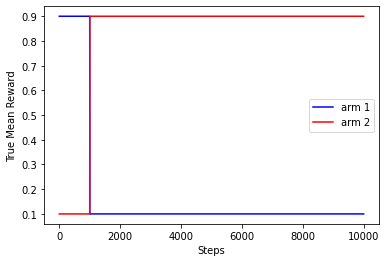

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.1] * 1000 + [0.9] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    # agent2 = UCBAgent('1', env, lr = 0.1)
    agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('1', env, Baseline_lr = None)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


In [ ]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.9
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


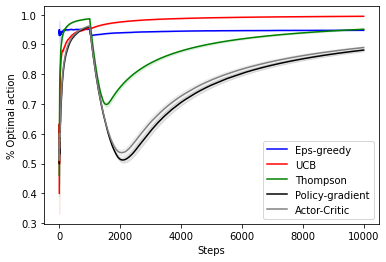

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

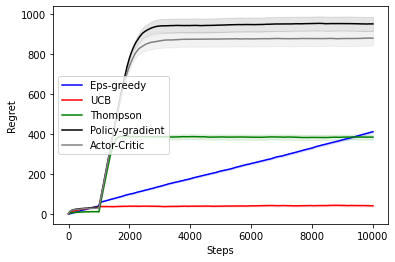

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

som5 = np.std(regret5,axis = 1) / np.sqrt(regret5.shape[1])
mean5 = np.mean(regret5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

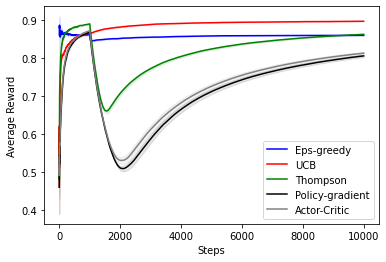

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

som5 = np.std(average_rewards5,axis = 1) / np.sqrt(average_rewards5.shape[1])
mean5 = np.mean(average_rewards5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Medium 

In [ ]:
env = MutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Med'], 10000, '1')

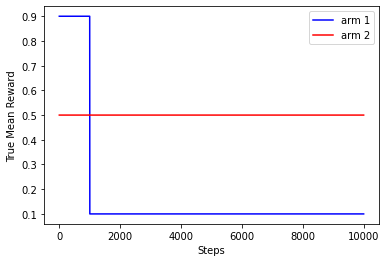

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.5] * 1000 + [0.5] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.5
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    # agent2 = UCBAgent('1', env, lr = 0.1)
    agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.5
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.5
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('1', env, Baseline_lr = None)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.5
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


In [ ]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)

    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.5
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


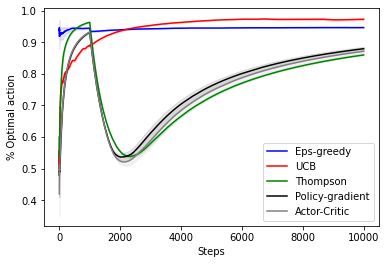

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

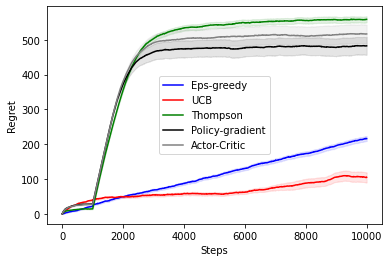

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

som5 = np.std(regret5,axis = 1) / np.sqrt(regret5.shape[1])
mean5 = np.mean(regret5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

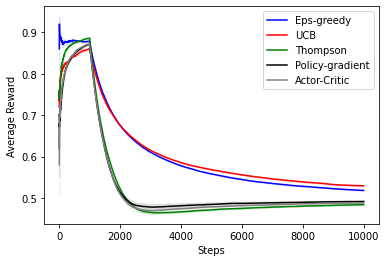

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

som5 = np.std(average_rewards5,axis = 1) / np.sqrt(average_rewards5.shape[1])
mean5 = np.mean(average_rewards5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Hard

In [ ]:
env = MutliArmedBanditEnvironment(Multinomial_Rewards['2arm_Hard'], 10000, '1')

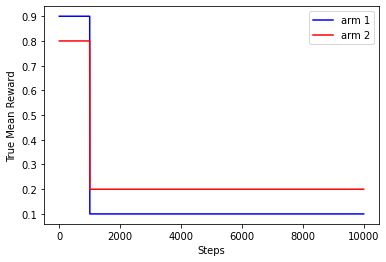

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.8] * 1000 + [0.2] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.2
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    # agent2 = UCBAgent('1', env, lr = 0.1)
    agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.2
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.2
            regret3[t,r] = 1000 * 0.9 + (t+1)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('1', env, Baseline_lr = None)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.2
            regret4[t,r] = 1000 * 0.9 +(t+1)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [ ]:

env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)
    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.2
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


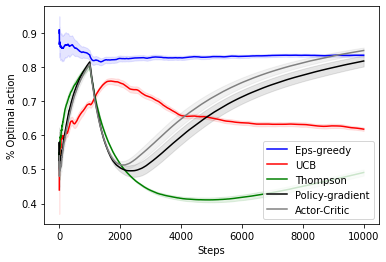

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

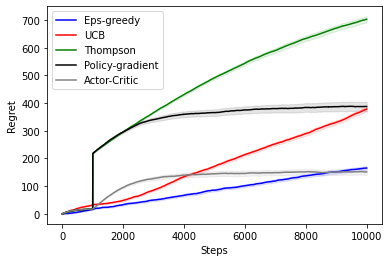

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

som5 = np.std(regret5,axis = 1) / np.sqrt(regret5.shape[1])
mean5 = np.mean(regret5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

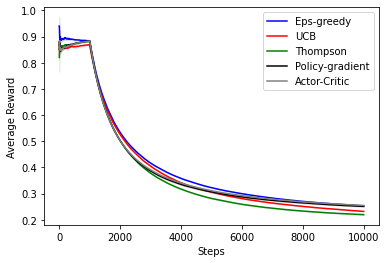

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

som5 = np.std(average_rewards5,axis = 1) / np.sqrt(average_rewards5.shape[1])
mean5 = np.mean(average_rewards5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

## 10 armed Bandit

In [ ]:
Multinomial_Rewards = {  '10arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                         MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.6,0.4], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.4,0.6], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.2,0.8], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.0,0.1], switch_t = 10000),] ,
                       
                         '10arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                         MultinomialReward_NonStationary([1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.9,0.1], switch_t = 10000),] }

### Medium 

In [ ]:
env = MutliArmedBanditEnvironment(Multinomial_Rewards['10arm_Med'], 10000, '1')

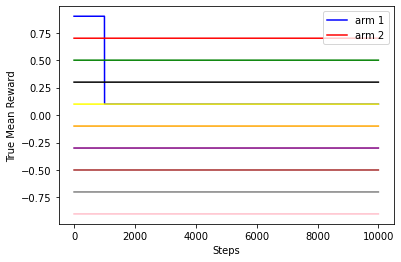

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.7] *10000),'r')
ax.plot(range(10000), np.array([0.5] *10000),'g')
ax.plot(range(10000), np.array([0.3] *10000),'black')
ax.plot(range(10000), np.array([0.1] *10000),'yellow')
ax.plot(range(10000), np.array([-0.1] *10000),'orange')
ax.plot(range(10000), np.array([-0.3] *10000),'purple')
ax.plot(range(10000), np.array([-0.5] *10000),'brown')
ax.plot(range(10000), np.array([-0.7] *10000),'gray')
ax.plot(range(10000), np.array([-0.9] *10000),'pink')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.7
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    # agent2 = UCBAgent('1', env, lr = 0.1)
    agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.7
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.7
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [02:44<00:00,  3.30s/it]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('1', env, Baseline_lr = None)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.7
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


In [ ]:
env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)
    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.7
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


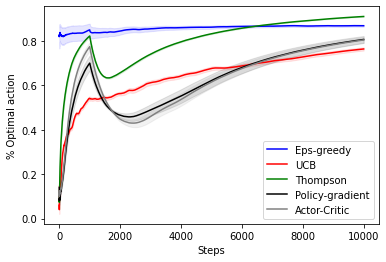

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

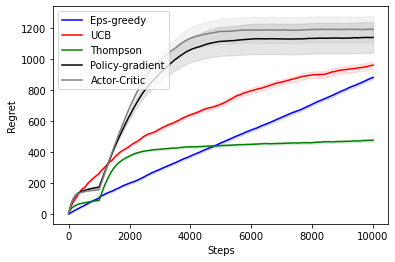

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

som5 = np.std(regret5,axis = 1) / np.sqrt(regret5.shape[1])
mean5 = np.mean(regret5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

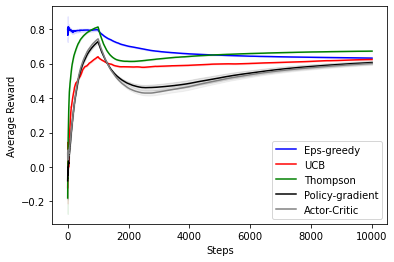

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

som5 = np.std(average_rewards5,axis = 1) / np.sqrt(average_rewards5.shape[1])
mean5 = np.mean(average_rewards5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

### Hard 

In [ ]:
env = MutliArmedBanditEnvironment(Multinomial_Rewards['10arm_Hard'], 10000, '1')

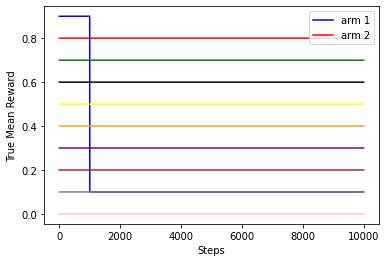

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.8] *10000),'r')
ax.plot(range(10000), np.array([0.7] *10000),'g')
ax.plot(range(10000), np.array([0.6] *10000),'black')
ax.plot(range(10000), np.array([0.5] *10000),'yellow')
ax.plot(range(10000), np.array([0.4] *10000),'orange')
ax.plot(range(10000), np.array([0.3] *10000),'purple')
ax.plot(range(10000), np.array([0.2] *10000),'brown')
ax.plot(range(10000), np.array([0.1] *10000),'gray')
ax.plot(range(10000), np.array([0.0] *10000),'pink')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9    
    agent1 = EpsilonGreedyAgent('1', env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent1.take_action()

        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.8
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0
    
    # agent2 = UCBAgent('1', env, lr = 0.1)
    agent2 = UCBBanditAgent('1',env, c = 2, lr = 0.1)
    
    for t in range(10000):
        rew , act, _ = agent2.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards

        else:
            opt_act_count += int(act == 1)
            exp_opt_act = 0.8
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


In [ ]:
env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9

    agent3 = ThompsonSamplingAgent('1', env)
    
    for t in range(10000):
        rew , act, _ = agent3.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards

        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.8
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0
    exp_opt_act = 0.9
    
    agent4 = GradientBanditAgent('1', env, Baseline_lr = None)
    
    for t in range(10000):
        rew , act, _ = agent4.take_action()
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.8
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


In [ ]:
env.reset()
regret5 = np.zeros((10000,50))
perc_opt_act5 = np.zeros((10000,50))
average_rewards5 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agent5 = ActorCriticAgent('1', env, lr = 0.1)
    # agent4 = gradientAgent('1',env, alpha = 0.1, Baseline_lr = 0.01)
    for t in range(10000):
        rew , act, _ = agent5.take_action()
        
        sum_rewards += rew
        
        if t < 1000:
            opt_act_count += int(act == 0)
            regret5[t,r] = (t+1)*exp_opt_act - sum_rewards
        
        else :
            opt_act_count += int(act == 1)
            exp_opt_act = 0.8
            regret5[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards

        perc_opt_act5[t,r] = opt_act_count / (t+1)
        average_rewards5[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


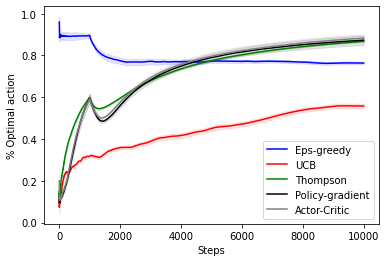

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

som5 = np.std(perc_opt_act5,axis = 1) / np.sqrt(perc_opt_act5.shape[1])
mean5 = np.mean(perc_opt_act5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

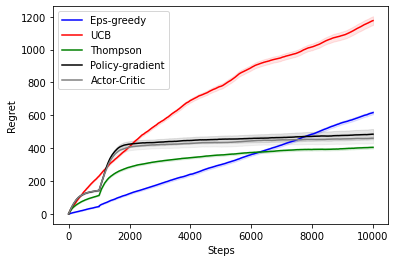

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

som5 = np.std(regret5,axis = 1) / np.sqrt(regret5.shape[1])
mean5 = np.mean(regret5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

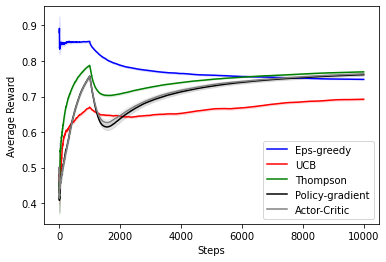

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

som5 = np.std(average_rewards5,axis = 1) / np.sqrt(average_rewards5.shape[1])
mean5 = np.mean(average_rewards5,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)
ax.plot(range(10000), mean5, 'gray')
ax.fill_between(range(10000), (mean5-som5), (mean5+som5), color='gray', alpha=.1)
ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["Eps-greedy", "UCB","Thompson", "Policy-gradient", "Actor-Critic" ])
plt.show()

# Second Section: Multi Agent

## 2 armed Bandit

In [ ]:
Multinomial_Rewards = {  '2arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 1000)] ,
                       
                         '2arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 1000)],
                       
                         '2arm_Easy' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                        MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 1000)]}                                   

### Easy

In [ ]:
env = MutliAgent_MAB_Environment(Multinomial_Rewards['2arm_Easy'], 10000, '1')

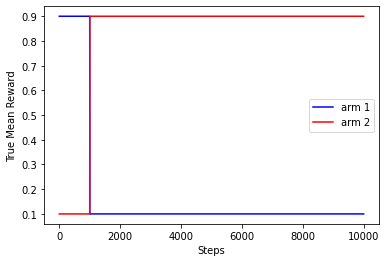

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.1] * 1000 + [0.9] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
exp_opt_act = 0.9

env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0

    agents1 = JAL_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents1.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
        else :
            opt_act_count += int(sum(actions) == 2)

        perc_opt_act1[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        regret1[t,r] = (t+1)*exp_opt_act - sum_rewards
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


In [ ]:
exp_opt_act = 0.9

env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0

    agents2 = FMQ_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1, nu = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents2.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
        else :
            opt_act_count += int(sum(actions) == 2)

        perc_opt_act2[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        regret2[t,r] = (t+1)*exp_opt_act - sum_rewards
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [ ]:
exp_opt_act = 0.9

env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0

    agents3 = Dis_Q_Agents(['1','2'], env, epsilon = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents3.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
        else :
            opt_act_count += int(sum(actions) == 2)

        perc_opt_act3[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


In [ ]:
exp_opt_act = 0.9

env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    sum_rewards = 0
    opt_act_count = 0

    agents4 = MultiAgentActorCritic(['1','2'], env, lr = 0.1, nu = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents4.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
        else :
            opt_act_count += int(sum(actions) == 2)

        perc_opt_act4[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


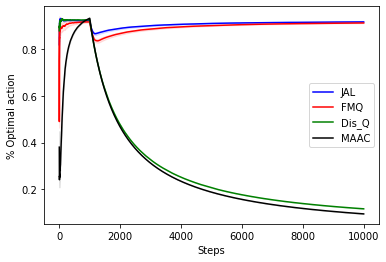

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL", "FMQ", "Dis_Q", "MAAC"])
plt.show()

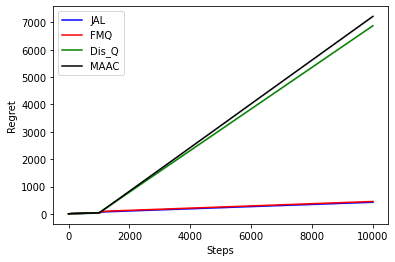

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL" , "FMQ", "Dis_Q","MAAC"])
plt.show()

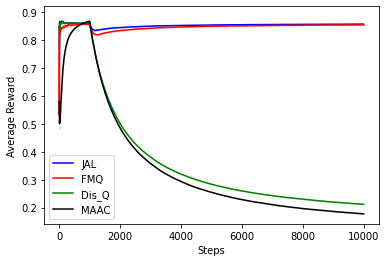

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL","FMQ", "Dis_Q","MAAC"])
plt.show()

### Medium 

In [ ]:
env = MutliAgent_MAB_Environment(Multinomial_Rewards['2arm_Med'], 10000, '1')

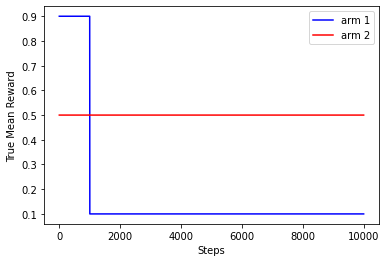

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.5] * 1000 + [0.5] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents1 = JAL_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents1.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.5
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act1[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


In [ ]:
env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents2 = FMQ_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1, nu = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents2.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.5
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act2[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


In [ ]:

env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents3 = Dis_Q_Agents(['1','2'], env, epsilon = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents3.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.5
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act3[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


In [ ]:
env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents4 = MultiAgentActorCritic(['1','2'], env, lr = 0.1, nu = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents4.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.5
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act4[t,r] = opt_act_count / (t+1)
        # print(opt_4act_count, t, perc_opt_act1[t,r])
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


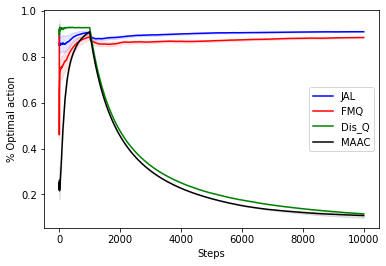

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL", "FMQ", "Dis_Q", "MAAC"])
plt.show()

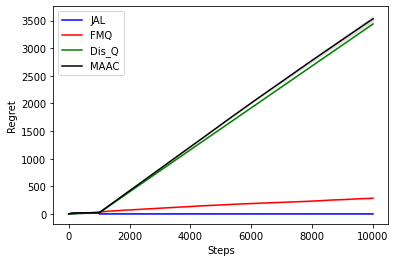

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL" , "FMQ", "Dis_Q","MAAC"])
plt.show()

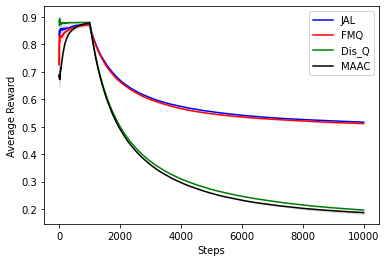

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL","FMQ", "Dis_Q","MAAC"])
plt.show()

### Hard

In [ ]:
env = MutliAgent_MAB_Environment(Multinomial_Rewards['2arm_Hard'], 10000, '1')

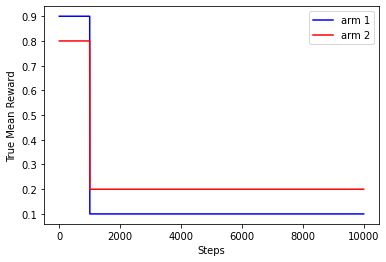

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.8] * 1000 + [0.2] * 9000),'r')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents1 = JAL_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents1.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.2
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act1[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [ ]:

env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents2 = FMQ_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1, nu = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents2.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.2
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act2[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


In [ ]:

env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents3 = Dis_Q_Agents(['1','2'], env, epsilon = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents3.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.2
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act3[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


In [ ]:

env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents4 = MultiAgentActorCritic(['1','2'], env, lr = 0.1, nu = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents4.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.2
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act4[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


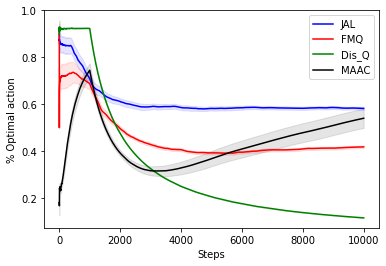

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL", "FMQ", "Dis_Q", "MAAC"])
plt.show()

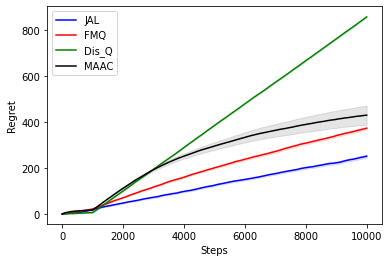

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL" , "FMQ", "Dis_Q","MAAC"])
plt.show()

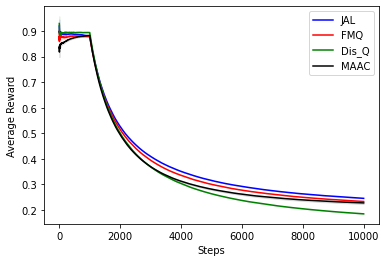

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL","FMQ", "Dis_Q","MAAC"])
plt.show()

## 10-armed Bandit

In [ ]:
Multinomial_Rewards = {  '10arm_Hard' : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                         MultinomialReward_NonStationary([1,0],[0.8,0.2], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.6,0.4], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.4,0.6], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.2,0.8], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.0,0.1], switch_t = 10000),] ,
                       
                         '10arm_Med'  : [MultinomialReward_NonStationary([1,0],[0.9,0.1], switch_t = 1000),
                                         MultinomialReward_NonStationary([1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.1,0.9], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.3,0.7], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.5,0.5], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.7,0.3], switch_t = 10000),
                                         MultinomialReward_NonStationary([-1,0],[0.9,0.1], switch_t = 10000),] }

### Medium 

In [ ]:
env = MutliAgent_MAB_Environment(Multinomial_Rewards['10arm_Med'], 10000, '1')

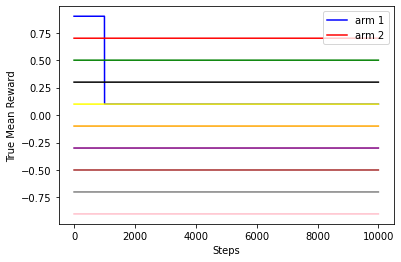

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.7] *10000),'r')
ax.plot(range(10000), np.array([0.5] *10000),'g')
ax.plot(range(10000), np.array([0.3] *10000),'black')
ax.plot(range(10000), np.array([0.1] *10000),'yellow')
ax.plot(range(10000), np.array([-0.1] *10000),'orange')
ax.plot(range(10000), np.array([-0.3] *10000),'purple')
ax.plot(range(10000), np.array([-0.5] *10000),'brown')
ax.plot(range(10000), np.array([-0.7] *10000),'gray')
ax.plot(range(10000), np.array([-0.9] *10000),'pink')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents1 = JAL_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents1.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.7
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act1[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [13:35<00:00, 16.32s/it]


In [ ]:

env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents2 = FMQ_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1, nu = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents2.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.7
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act2[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


In [ ]:

env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents3 = Dis_Q_Agents(['1','2'], env, epsilon = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents3.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.7
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act3[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


In [ ]:

env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents4 = MultiAgentActorCritic(['1','2'], env, lr = 0.1, nu = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents4.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.7
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act4[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


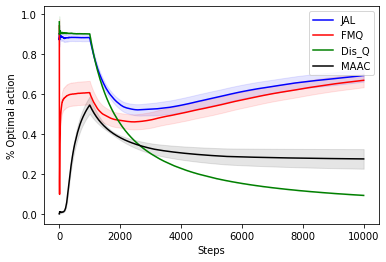

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL", "FMQ", "Dis_Q", "MAAC"])
plt.show()

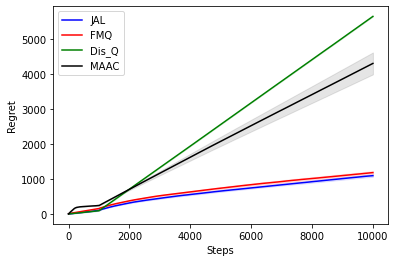

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL" , "FMQ", "Dis_Q","MAAC"])
plt.show()

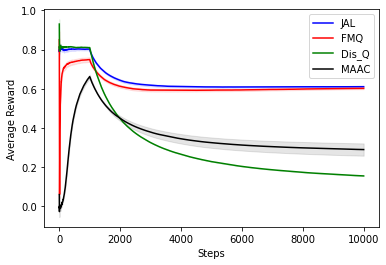

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL","FMQ", "Dis_Q","MAAC"])
plt.show()

### Hard

In [ ]:
env = MutliAgent_MAB_Environment(Multinomial_Rewards['10arm_Hard'], 10000, '1')

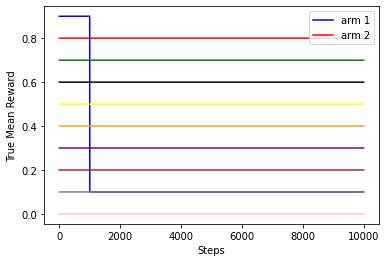

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(10000), np.array([0.9] * 1000 + [0.1] * 9000), 'b')
ax.plot(range(10000), np.array([0.8] *10000),'r')
ax.plot(range(10000), np.array([0.7] *10000),'g')
ax.plot(range(10000), np.array([0.6] *10000),'black')
ax.plot(range(10000), np.array([0.5] *10000),'yellow')
ax.plot(range(10000), np.array([0.4] *10000),'orange')
ax.plot(range(10000), np.array([0.3] *10000),'purple')
ax.plot(range(10000), np.array([0.2] *10000),'brown')
ax.plot(range(10000), np.array([0.1] *10000),'gray')
ax.plot(range(10000), np.array([0.0] *10000),'pink')

ax.set_ylabel('True Mean Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["arm 1", "arm 2"])
plt.show()

In [ ]:
env.reset()
regret1 = np.zeros((10000,50))
perc_opt_act1 = np.zeros((10000,50))
average_rewards1 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents1 = JAL_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents1.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret1[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.8
            regret1[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act1[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards1[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [13:37<00:00, 16.34s/it]


In [ ]:

env.reset()
regret2 = np.zeros((10000,50))
perc_opt_act2 = np.zeros((10000,50))
average_rewards2 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents2 = FMQ_Agents(['1','2'], env, epsilon = 0.1, lr = 0.1, nu = 0.1)
    
    for t in range(10000):
        rew, actions, _ = agents2.take_action()
        # print(rew, act, agent1.get_Q())
        sum_rewards += rew

        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret2[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.8
            regret2[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act2[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards2[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


In [ ]:

env.reset()
regret3 = np.zeros((10000,50))
perc_opt_act3 = np.zeros((10000,50))
average_rewards3 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents3 = Dis_Q_Agents(['1','2'], env, epsilon = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents3.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret3[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.8
            regret3[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act3[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards3[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


In [ ]:

env.reset()
regret4 = np.zeros((10000,50))
perc_opt_act4 = np.zeros((10000,50))
average_rewards4 = np.zeros((10000,50))

for r in tqdm(range(50)):
    exp_opt_act = 0.9
    sum_rewards = 0
    opt_act_count = 0

    agents4 = MultiAgentActorCritic(['1','2'], env, lr = 0.1, nu = 0.1)
    
    for t in range(10000):

        rew, actions, _ = agents4.take_action()

        sum_rewards += rew
        if t < 1000:
            opt_act_count += int(sum(actions) == 0)
            regret4[t,r] = (t+1)*exp_opt_act - sum_rewards
        else :
            opt_act_count += int(sum(actions) == 2)
            exp_opt_act = 0.8
            regret4[t,r] = 1000 * 0.9 + (t+1 - 1000)*exp_opt_act - sum_rewards
            
        perc_opt_act4[t,r] = opt_act_count / (t+1)
        # print(opt_act_count, t, perc_opt_act1[t,r])
        average_rewards4[t,r] = sum_rewards / (t+1)

    env.reset()

100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


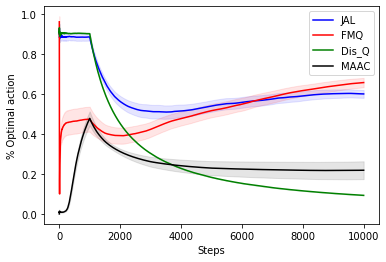

In [ ]:
som1 = np.std(perc_opt_act1,axis = 1) / np.sqrt(perc_opt_act1.shape[1])
mean1 = np.mean(perc_opt_act1,axis = 1)

som2 = np.std(perc_opt_act2,axis = 1) / np.sqrt(perc_opt_act2.shape[1])
mean2 = np.mean(perc_opt_act2,axis = 1)

som3 = np.std(perc_opt_act3,axis = 1) / np.sqrt(perc_opt_act3.shape[1])
mean3 = np.mean(perc_opt_act3,axis = 1)

som4 = np.std(perc_opt_act4,axis = 1) / np.sqrt(perc_opt_act4.shape[1])
mean4 = np.mean(perc_opt_act4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('% Optimal action',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL", "FMQ", "Dis_Q", "MAAC"])
plt.show()

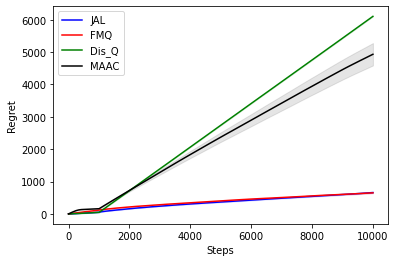

In [ ]:
som1 = np.std(regret1,axis = 1) / np.sqrt(regret1.shape[1])
mean1 = np.mean(regret1,axis = 1)

som2 = np.std(regret2,axis = 1) / np.sqrt(regret2.shape[1])
mean2 = np.mean(regret2,axis = 1)

som3 = np.std(regret3,axis = 1) / np.sqrt(regret3.shape[1])
mean3 = np.mean(regret3,axis = 1)

som4 = np.std(regret4,axis = 1) / np.sqrt(regret4.shape[1])
mean4 = np.mean(regret4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Regret',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL" , "FMQ", "Dis_Q","MAAC"])
plt.show()

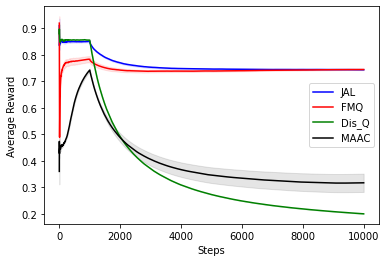

In [ ]:
som1 = np.std(average_rewards1,axis = 1) / np.sqrt(average_rewards1.shape[1])
mean1 = np.mean(average_rewards1,axis = 1)

som2 = np.std(average_rewards2,axis = 1) / np.sqrt(average_rewards2.shape[1])
mean2 = np.mean(average_rewards2,axis = 1)

som3 = np.std(average_rewards3,axis = 1) / np.sqrt(average_rewards3.shape[1])
mean3 = np.mean(average_rewards3,axis = 1)

som4 = np.std(average_rewards4,axis = 1) / np.sqrt(average_rewards4.shape[1])
mean4 = np.mean(average_rewards4,axis = 1)

fig, ax = plt.subplots()
ax.plot(range(10000), mean1, 'b')
ax.fill_between(range(10000), (mean1-som1), (mean1+som1), color='b', alpha=.1)
ax.plot(range(10000), mean2,'r')
ax.fill_between(range(10000), (mean2-som2), (mean2+som2), color='r', alpha=.1)
ax.plot(range(10000), mean3, 'g')
ax.fill_between(range(10000), (mean3-som3), (mean3+som3), color='g', alpha=.1)
ax.plot(range(10000), mean4, 'black')
ax.fill_between(range(10000), (mean4-som4), (mean4+som4), color='black', alpha=.1)

ax.set_ylabel('Average Reward',rotation = 90)
ax.set_xlabel('Steps')
ax.legend(["JAL","FMQ", "Dis_Q","MAAC"])
plt.show()

# Third Section: Social Learning

In [ ]:
class Social_NArmedBanditEnvironment():
    def __init__(self, arm_count,rewards,episode_max_length, container = None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        self.action_space = action_space
        self.observation_space = state_space
        self.id = id
        self.agents = {}
        
        if container != None:
            container.register_environment(self)
        self.arm_count = arm_count
        self.arms_rewards = rewards
        self.agents_last_choice = []
        # self.optimal_action = np.argmax(R_mean)
        
        self.agents_last_choice = []
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }
    
    def add_agent(self):
        self.agents_last_choice.append(-1) 
     
    def calculate_reward(self, action):
        return self.arms_rewards[action].get_reward(self.state['length'])
    
    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action
        
    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe(agent_id)
        info = self.get_info(action)
        self.next_state(action)
        done = self.terminated()
        self.update_selected(action, agent_id)
        return observation, reward
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self,agent_id):
        return {}
    
    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action
    
    def get_info(self, action):
        return {} 

    def config(self):
        self.agents_last_choice = []
    
    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [ ]:
class Reward():
    def __init__(self, mean, var):
        self.m = mean
        self.var = var
    
    def get_reward(self):
        return np.random.normal(loc=self.m, scale=np.sqrt(self.var))

In [ ]:
class ThompsonAgent:
    def __init__(self, id, environment, uf = [1,1,1,1], Ts_mean = 0, Ts_var = 1000):
        self.id = id
        self.uf = uf
        self.environment = environment
        self.environment.add_agent()
        self.Ts_rewards = []
        self.rewards_sum = np.zeros(self.environment.arm_count)
        self.rewards_count = np.zeros(self.environment.arm_count)
        for i in range(self.environment.arm_count):
            self.Ts_rewards.append(Reward(Ts_mean,Ts_var))
    def select_action(self):
        sample = [self.Ts_rewards[i].get_reward() for i in range(self.environment.arm_count)]
        return np.argmax(sample)
    def update_arm(self, Ri, index):
        self.rewards_sum[index] = self.rewards_sum[index] + Ri
        self.rewards_count[index] = self.rewards_count[index] + 1
        tau = 1/self.Ts_rewards[index].var
        self.Ts_rewards[index].m = (self.Ts_rewards[index].m * tau + self.rewards_sum[index])/ (self.rewards_count[index] + tau)
        tau = tau + 1
        self.Ts_rewards[index].var = 1/tau
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm,self.id)
        self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
class greedyAgent:
    def __init__(self, id, environment, uf = [1,1,1,1]):
        self.id = id
        self.uf = uf
        # Step count
        self.n = 0
        self.environment = environment
        if id != -1:
            self.environment.add_agent()
        self.k = environment.arm_count
        # Step count for each arm
        self.k_n = np.zeros(self.k)
        # Total mean reward
        self.mean_reward = 0
        # Mean reward for each arm
        self.k_reward = np.zeros(self.k)
    def select_action(self):
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            return np.random.choice(self.k)
        else:
            return np.argmax(self.k_reward)
    
    
    def UF(self, Ri):
        if Ri > 0:
            return self.uf[0]*Ri**self.uf[1]
        if Ri < 0:
            return -1*self.uf[3]*(-1*Ri)**self.uf[2]
        return 0
    
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        Ri = self.UF(Ri)
        self.n += 1
        self.k_n[index_selected_arm] += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.k_reward[index_selected_arm] = self.k_reward[index_selected_arm] + (Ri - self.k_reward[index_selected_arm]) / self.k_n[index_selected_arm]
        return obs, Ri, index_selected_arm
    def update_arm(self, Ri, index_selected_arm):
        self.n += 1
        self.k_n[index_selected_arm] += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.k_reward[index_selected_arm] = self.k_reward[index_selected_arm] + (Ri - self.k_reward[index_selected_arm]) / self.k_n[index_selected_arm]
class  BoltzmannAgent():
    
    def __init__(self, id, environment):
        self.environment = environment
        self.environment.add_agent()
        self.temp_pull_count   = np.zeros(environment.arm_count)
        self.temp_estimation   = np.zeros(environment.arm_count) + 1/environment.arm_count
        self.id = id
        self.tempture = 10
        
    def select_action(self):
        pi  = np.exp(self.temp_estimation/self.tempture) / np.sum(np.exp(self.temp_estimation/self.tempture))
        current_choice = np.random.choice(self.environment.arm_count,p=pi)
        return current_choice
    
    def update_arm(self, Ri, current_choice):
        self.temp_pull_count[current_choice] = self.temp_pull_count[current_choice] + 1
        self.temp_estimation[current_choice] = self.temp_estimation[current_choice] + (1/(self.temp_pull_count[current_choice]+1)) * (Ri-self.temp_estimation[current_choice])
        if self.tempture > 1:
            self.tempture = self.tempture * 0.9
        else:
            self.tempture =  0.1
        return
    
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
class gradientAgent():
    
    def __init__(self, id, environment, alpha = 0.1):
        self.environment = environment
        self.environment.add_agent()
        self.k = self.environment.arm_count
        self.actions = np.arange(self.k)
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        self.alpha = alpha
        self.id = id
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)

    def select_action(self):
      # Update probabilities
        self.softmax()
        # Select highest preference action
        a = np.random.choice(self.actions, p=self.prob_action)
        return a
    def update_arm(self, reward, a):
        # Update counts
        self.n += 1
        self.k_n[a] += 1
         
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
         
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
         
        # Update preferences
        self.H[a] = self.H[a] + self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
        actions_not_taken = self.actions!=a
        self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]

        
    def take_action(self):
        a = self.select_action()  
        obs, reward = self.environment.step(a, self.id)
        self.update_arm(reward, a)
        return obs, reward, a

class UCB():
    def __init__(self, id, environment,c_level = 0.9):
        self.actions_range = range(environment.arm_count)
        self.actions = [i for i in self.actions_range]
        self.Q = [0 for i in self.actions_range]
        self.n = [0 for i in self.actions_range]
        self.UCBs = [float('inf') for i in self.actions_range]
        self.total_reward = 0
        self.confidence_level=c_level
        self.iteration = 0
        self.environment = environment
        environment.add_agent()
        self.trial = 0
        

    def uncertainty(self, iteration, index):
        if self.n[index] == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(iteration) / self.n[index])) 


    def update_ucb(self, iteration, index):
        self.UCBs[index] =  self.Q[index] + self.uncertainty(iteration,index)
        return

    def update_belief(self, i, R):
        self.trial +=1
        self.n[i] +=1
        self.Q[i] = (1 - 1.0/self.n[i]) * self.Q[i]+ (1.0/(self.n[i]+1)) * R
        return

    def get_total_reward(self, R):
        self.total_reward += R
        return self.total_reward

    def get_optimal(self, index_of_Q):
        self.optimal[self.trial-1] = self.n[index_of_Q]/ self.trial

    def select_action(self):
      return np.argmax(self.UCBs)

    def update_arm(self, Ri, index_selected_arm):
      self.update_belief(index_selected_arm, Ri)
      self.update_ucb(self.iteration,index_selected_arm)



    def take_action(self) -> (object, float, bool, object):
        self.iteration += 1
        available_actions = [ i for i in range(self.environment.arm_count)]
        action = self.select_action()
        obs, r = self.environment.step(action,0)
        self.update_belief( action, r)
        self.update_ucb(self.iteration,action)
        return obs, r, action

Coded agents:

In [ ]:
class alwaysBestAgent():
    def __init__(self,environment, alpha, uf, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmax([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)
        
        return obs, Ri, index_selected_arm
    
class percentBestAgent():
    def __init__(self,environment, alpha, uf, id, p, increase = 0, limit = 1, zero_at = False):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmax([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        self.p = p
        self.increase = increase
        self.zero_at = zero_at
        self.limit = limit
        
        
    def take_action(self):
        if np.random.rand()<self.p:
            index_selected_arm = self.bestaction
        else:
            index_selected_arm = np.random.choice([i for i in range(self.environment.arm_count)])
        self.p = self.p + self.increase
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)
        if self.p > self.limit:
            self.p = self.limit
            self.increase = 0
        if self.zero_at:
            if self.p > 1:
                self.p = 0
                self.increase = 0
        return obs, Ri, index_selected_arm
    
class secondBestAgent():
    def __init__(self,environment, alpha, uf, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.array([r.m for r in self.environment.rewards]).argsort()[-2] #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm   
    
class alwaysWorstAgent():
    def __init__(self,environment, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmin([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm

class alwaysRandomAgent():
    def __init__(self,environment, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmin([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = np.random.choice(self.environment.arm_count)
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm

In [ ]:
class SocialAgent():
    def __init__(self,environment, alpha, id, preferencelearner= None, noize = 0, limit = 100000):
        self.environment = environment
        self.individual = greedyAgent(environment = environment,id = id)
        self.id = id
        self.preference = np.zeros(len(self.environment.agents_last_choice))+0.0001
        self.prob = 10
        self.history = []
        # Total mean reward
        self.mean_reward = 0
        self.n = 0
        # Mean reward for each arm
        self.preference_history = {}
        self.frequency = np.zeros((len(self.environment.agents_last_choice),environment.arm_count))
        self.noize = noize
        self.limit = limit
        for i in range(len(self.preference)):
            self.preference_history[i] = []
        
    def update_social_preference(self, index, Ri, index_selected_arm, alpha = 0.1):
        '''Update others with same action selected:'''
        #alpha = 1/len(self.environment.agents_last_choice)
        same = [i for i in range(len(self.environment.agents_last_choice)) if self.environment.agents_last_choice[i]==index_selected_arm]
        #same.remove(self.id)
        if self.id not in same:
            if self.individual.select_action() == index_selected_arm:
                same.append(self.id)
        self.preference = np.round(self.preference,2)
        d = np.sum(np.exp(self.preference))
        mask = np.ones(len(self.preference))*alpha
        self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        for index in same:
            self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)
        return
    
    def select_agent_social(self):
        '''calculate action frequency'''
        for i in range(len(self.preference)):
            self.frequency[i][self.environment.agents_last_choice[i]] += 1
        p = np.round(np.exp(np.round(self.preference,2)),2)
        p = p/np.sum(p)
        for j in range(len(p)):
            if np.isnan(p[j]):
                p[j] = 1
        for i in range(len(self.preference)):
            self.preference_history[i].append(p[i]/np.sum(p))
        ind = np.random.choice(len(self.preference),p = p/np.sum(p))
        return ind
    
    def take_action_social(self) -> (object, float):
        ind = self.select_agent_social()
        if ind == self.id or len(self.environment.agents_last_choice)==1 or self.n > self.limit:
            self.history.append(-1)
            index_selected_arm = self.individual.select_action()
            obs, Ri = self.environment.step(index_selected_arm, self.id)
            self.individual.update_arm(Ri, index_selected_arm)
        else:
            '''select most frequent'''
            self.history.append(ind)
            index_selected_arm = self.environment.agents_last_choice[ind]
            #np.argmax(self.frequency[ind])
            if np.random.rand() < self.noize:
                index_selected_arm = np.random.choice([i for i in range(self.environment.arm_count) if i != index_selected_arm])
            obs, Ri = self.environment.step(index_selected_arm, self.id)
            self.individual.update_arm(Ri, index_selected_arm)
        self.n += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.update_social_preference(ind,Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
    
    def take_action(self):
        obs, Ri, indx = self.take_action_social()
        return obs, Ri, indx

In [ ]:
class Sciety():
    def __init__(self, env=None, thompson_agent = 0, percent_agents = 1, p = [0.01], increase = [0.005], limit = [0.9], worst_agents = 1, random_agents = 4, UCBagent = 0):
        self.agents = []
        self.names = []
        self.thompson_agent, self.percent_agents , self.p , self.increase , self.limit, self.worst_agents , self.random_agents, self.env = thompson_agent , percent_agents , p , increase , limit , worst_agents , random_agents, env
        self.historyTotal = {}
        self.UCBagent = UCBagent
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotal[i] = []
        self.historyTotalR = {}
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotalR[i] = []
        
    def reset(self, env):
        self.env = env
        self.agents = []
        self.names = []
        for i in range(self.UCBagent):
            self.agents.append(UCB(environment = self.env,id = len(self.agents)))
        for i in range(self.thompson_agent):
            self.agents.append(ThompsonAgent(environment = self.env,id = len(self.agents)))
            self.names.append("thompson")
        for i in range(self.random_agents):
            self.agents.append(alwaysRandomAgent(self.env,len(self.agents)))
            self.names.append("random")
        for i in range(self.percent_agents):
            self.agents.append(percentBestAgent(self.env,0.1,[1,1,1,1],len(self.agents), self.p[i], self.increase[i],self.limit[i]))
            self.names.append("percent("+str(self.p[i])+","+str(self.increase[i])+","+str(self.limit[i])+")")
        for i in range(self.worst_agents):
            self.agents.append(alwaysWorstAgent(self.env,len(self.agents)))
            self.names.append("worst")
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
        
    def step(self):
        for a in range(len(self.agents)):
            obs, Ri, index_selected_arm = self.agents[a].take_action()
            self.history[a].append(index_selected_arm)
            self.historyR[a].append(Ri)
    def historyRecord(self):
        for a in range(len(self.agents)):
            self.historyTotal[a].append(self.history[a])
            self.historyTotalR[a].append(self.historyR[a])
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
    def getCategories(self):
        temp = {}
        index = []
        for n in range(len(self.names)):
            if self.names[n] not in temp.keys() or "percent" in self.names[n]:
                temp[self.names[n]] = 0
                index.append(n)
        return index

In [ ]:
class SocialLearning:
    def __init__(self, learner, society, individual, k_n_thr = 0, limit = 10000):
        self.learner = learner
        self.society = society
        self.individual = individual
        self.history = []
        self.historyR = []
        self.historyindividual = []
        self.historyindividualR = []
        self.best = []
        self.bestR = []
        self.preference_history = {}
        self.id = 0
        self.k_n_thr = k_n_thr
        self.limit = limit

    def iteration(self, env, trial_cnt, preferencelearner, threshold = 1000, noize = 0):
        self.society.reset(env)
        history = []
        historyR = []
        historyindividual = []
        historyindividualR = []
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            socialLearner = self.learner(env,0.1,len(self.society.agents), preferencelearner, noize, self.limit)
            self.id = socialLearner.id
        else:
            socialLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            self.society.step()
            obs, Ri, index_selected_arm = socialLearner.take_action()
            history.append(index_selected_arm)
            historyR.append(Ri)
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            for i in range(len(socialLearner.preference_history)):
                self.preference_history[i].append(socialLearner.preference_history[i])
        individualLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            obs, Ri, index_selected_arm = individualLearner.take_action()
            historyindividual.append(index_selected_arm)
            historyindividualR.append(Ri)
        self.historyindividual.append(historyindividual)
        self.historyindividualR.append(historyindividualR)
        self.society.historyRecord()
        self.history.append(history)
        self.historyR.append(historyR)
    def loop(self, epoch = 10, iteration = 10, vars = [], rewards = [(i-100)/10 for i in range(200)], threshold = 1000, noize = 0, n = [100], reward_var = None, reward_means = None, random_reward = True, k = None, preferencelearner = None):
        for i in range(len(self.society.historyTotal.keys())+1):
            self.preference_history[i] = []
        for (reward_means,reward_var) in zip(rewards, vars):
            for i in range(iteration):               
                env = NArmedBanditEnvironment(len(reward_means), reward_means, reward_var)
                self.iteration(env, 1000, preferencelearner)
                self.best.append(np.argmax(reward_means))
                self.bestR.append(np.max(reward_means))
    def optimalaction(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [0]
            for index_selected_arm in hist[i]:
                temp.append(temp[-1]+int(index_selected_arm==self.best[i]))
            temp = temp[1:]
            for t in range(len(temp)):
                temp[t] = temp[t]/(t+1)
            poa.append(temp)
        return poa
    def regret(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [((j+1)*self.bestR[i]-np.sum(hist[i][0:j])) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def creward(self, hist):
        poa = []
        for i in range(len(hist)):
            poa.append(hist[i])
        return poa
    def regretc(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [(self.bestR[i]-hist[i][j]) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def compare(self, all = False):
        if all:
            index = [i for i in range(len(self.society.agents))]
        else:
            index = self.society.getCategories()
        data = {}
        data["history action"] = self.history
        data["history reward"] = self.historyR
        data["index"] = index
        data["history individual action"] = self.historyindividual
        data["history individual reward"] = self.historyindividualR
        data["optimal action"] = self.best
        data["optimal action reward"] = self.bestR
        tmp = {}
        tmp["social"] = self.preference_history[self.id]
        for i in index:
            tmp[self.society.names[i]] = self.preference_history[i]
        data["preference"] = tmp
        poa = {}
        poa["social"] = self.optimalaction(self.history)
        poa["individual"] = self.optimalaction(self.historyindividual)
        for i in index:
            poa[self.society.names[i]] = self.optimalaction(self.society.historyTotal[i])
        data["percent of selecting the optimal action"] = poa
        poa = {}
        poa["social"] = self.regret(self.historyR)
        poa["individual"] = self.regret(self.historyindividualR)
        data["regret"] = poa
        poa = {}
        poa["social"] = self.regretc(self.historyR)
        poa["individual"] = self.regretc(self.historyindividualR)
        data["regretc"] = poa
        poa = {}
        poa["social"] = self.creward(self.historyR)
        poa["individual"] = self.creward(self.historyindividualR)
        data["creward"] = poa
        return data

### Visualization

In [ ]:
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
class tools:
    def __init__(self):
        drive.mount('/content/gdrive')
    def Visual(self, data, t = 1000, save = False, name = "", std = True, limit = True, line = True, label = "difference of the percent of best action selection social and individual"):
        fig, ax = plt.subplots()
        clrs = sns.color_palette("husl", len(data.keys()))
        with sns.axes_style("darkgrid"):
            epochs = list(range(t))
            for (x, c) in zip(data.keys(),clrs):
                meanst = np.mean(data[x],axis = 0)
                sdt = 2*np.std(data[x], axis = 0, ddof = 0)/np.sqrt(np.shape(data[x])[0])
                ax.plot(epochs, meanst, label=x, c=c)
                if std:
                    ax.fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=c)
            if line:
                ax.plot(epochs, np.zeros(t), linestyle='dotted', c='black')
            ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
            plt.xlabel("trial")
            ax.xaxis.label.set_fontsize(12)
            ax.yaxis.label.set_fontsize(12)
            plt.ylabel(label)
            if limit:
                plt.ylim([0,1])
        if save:
            fig.savefig(name, dpi=1200, bbox_inches="tight")
    def save(self, data, name):
        np.save(name, data) 
    def load(self, name):
        return np.load(name,allow_pickle='TRUE').item()

In [ ]:
def create_means_d(n, rewards, repeate, d):
    reward_means = []
    reward_vars = []
    
    for j in range(repeate):
        k = n[0]
        distance = [i for i in range(k)]
        reward_mean = np.random.choice(rewards)
        reward_mean = np.array(distance)*d+reward_mean
        reward_mean = np.sort(reward_mean)
        reward_var = np.ones(k)
        reward_means.append(reward_mean)
        reward_vars.append(reward_var)
    return reward_means, reward_vars

In [ ]:
def create_means(n, rewards, repeate):
    reward_means = []
    reward_vars = []
    
    for j in range(repeate):
        k = n[0]
        reward_mean = np.random.choice(rewards,k, replace=False)
        reward_mean = np.sort(reward_mean)
        reward_var = np.ones(k)
        reward_means.append(reward_mean)
        reward_vars.append(reward_var)
    return reward_means, reward_vars

### Results

In [ ]:
class SocialLearning1:
    def __init__(self, learner, society, individual, k_n_thr = 0, limit = 10000, beta1 = None, beta2 = None):
        self.learner = learner
        self.society = society
        self.individual = individual
        self.history = []
        self.historyR = []
        self.historyindividual = []
        self.historyindividualR = []
        self.best = []
        self.bestR = []
        self.preference_history = {}
        self.id = 0
        self.k_n_thr = k_n_thr
        self.limit = limit
        self.beta1=  beta1
        self.beta2 = beta2

    def iteration(self, env, trial_cnt, preferencelearner, threshold = 1000, noize = 0):
        self.society.reset(env)
        history = []
        historyR = []
        historyindividual = []
        historyindividualR = []
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            if self.beta1 is not None:
                socialLearner = self.learner(len(self.society.agents), env, c_level = 0.9, beta1 = self.beta1, beta2 = self.beta2)
            else:
                socialLearner = self.learner(len(self.society.agents), env, c_level = 0.9)
            self.id = socialLearner.id
        else:
            socialLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            self.society.step()
            obs, Ri, index_selected_arm = socialLearner.take_action()
            history.append(index_selected_arm)
            historyR.append(env.rewards[index_selected_arm].m)
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            for i in range(len(socialLearner.preference_history)):
                self.preference_history[i].append(socialLearner.preference_history[i])
        individualLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            obs, Ri, index_selected_arm = individualLearner.take_action()
            historyindividual.append(index_selected_arm)
            historyindividualR.append(env.rewards[index_selected_arm].m)
        self.historyindividual.append(historyindividual)
        self.historyindividualR.append(historyindividualR)
        self.society.historyRecord()
        self.history.append(history)
        self.historyR.append(historyR)
    def loop(self, epoch = 10, iteration = 10, vars = [], rewards = [(i-100)/10 for i in range(200)], threshold = 1000, noize = 0, n = [100], reward_var = None, reward_means = None, random_reward = True, k = None, preferencelearner = None):
        for i in range(len(self.society.historyTotal.keys())+1):
            self.preference_history[i] = []
        for (reward_means,reward_var) in zip(rewards, vars):
            for i in range(iteration):
                env = NArmedBanditEnvironment(len(reward_means), reward_means, reward_var)
                self.iteration(env, 1000, preferencelearner)
                self.best.append(np.argmax(reward_means))
                self.bestR.append(reward_means[np.argmax(reward_means)])
    def optimalaction(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [0]
            for index_selected_arm in hist[i]:
                temp.append(temp[-1]+int(index_selected_arm==self.best[i]))
            temp = temp[1:]
            for t in range(len(temp)):
                temp[t] = temp[t]/(t+1)
            poa.append(temp)
        return poa
    def regret(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [((j+1)*self.bestR[i]-np.sum(hist[i][0:j])) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def regretc(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [(self.bestR[i]-hist[i][j]) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def compare(self, all = False):
        if all:
            index = [i for i in range(len(self.society.agents))]
        else:
            index = self.society.getCategories()
        data = {}
        data["history action"] = self.history
        data["history reward"] = self.historyR
        data["index"] = index
        data["history individual action"] = self.historyindividual
        data["history individual reward"] = self.historyindividualR
        data["optimal action"] = self.best
        data["optimal action reward"] = self.bestR
        tmp = {}
        tmp["social"] = self.preference_history[self.id]
        for i in index:
            tmp[self.society.names[i]] = self.preference_history[i]
        data["preference"] = tmp
        poa = {}
        poa["social"] = self.optimalaction(self.history)
        poa["individual"] = self.optimalaction(self.historyindividual)
        for i in index:
            poa[self.society.names[i]] = self.optimalaction(self.society.historyTotal[i])
        data["percent of selecting the optimal action"] = poa
        poa = {}
        poa["social"] = self.regret(self.historyR)
        poa["individual"] = self.regret(self.historyindividualR)
        data["regret"] = poa
        poa = {}
        poa["social"] = self.regretc(self.historyR)
        poa["individual"] = self.regretc(self.historyindividualR)
        data["regretc"] = poa
        return data

In [ ]:
class  OUCB:    
    def __init__(self, id, environment, c_level = 0.9, beta1 = 0.5, beta2 = 0.5):
        self.environment = environment
        self.environment.add_agent()
        self.Q_value   = np.zeros(environment.arm_count)
        self.T   = np.ones(environment.arm_count) * 1000
        self.action_counts = np.zeros(environment.arm_count)
        self.UCB_action_count = np.ones((len(self.environment.agents_last_choice),environment.arm_count))
        self.id = id
        self.n = 1
        self.c_level = c_level
        self.preference_history = {}
        self.beta1 = beta1
        self.beta2 = beta2
        for i in range(len(self.environment.agents_last_choice)):
            self.preference_history[i] = []
        
    def update_arm(self, Ri, index_selected_arm):
        self.Q_value[index_selected_arm] = self.Q_value[index_selected_arm] * self.T[index_selected_arm] + Ri 
        self.T[index_selected_arm] = self.T[index_selected_arm] + 1  
        self.Q_value[index_selected_arm] = self.Q_value[index_selected_arm]/ self.T[index_selected_arm]
        return self.Q_value, self.T     
    def select_action(self):
        #calculate sqrt
        temp_action_count = np.mean(self.UCB_action_count, axis =0)
        ucb = []
        for i in range(len(self.T)):
            if self.T[i] !=0 :
                target_term = (temp_action_count[i] - self.action_counts[i]) / np.sum(self.T)
                target_optimism = target_term if target_term>0 else 0
                ucb.append(self.Q_value[i] + self.c_level * np.sqrt(2*np.log(np.sum(self.T))/self.action_counts[i]) * (self.beta1 + self.beta2*target_optimism))
            else:
                ucb.append(np.inf)
        return np.argmax(ucb)
    def take_action(self):
        for i in range(len(self.environment.agents_last_choice)):
            self.UCB_action_count[i][self.environment.agents_last_choice[i]] += 1
        
        index_selected_arm = self.select_action()
        self.action_counts[index_selected_arm] += 1
        # print(index_selected_arm, self.id, "target")
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        self.Q_value, self.T =self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm

In [ ]:
resultindividual = {}
resultsocial = {}
resultdifference = {}
epoch = +30
k = 10
rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)

In [ ]:
result = {}
resultR = {}
resultRc = {}
thompson_agent = 1
percent_agents = 0
p = [0.01]
increase = [0.005]
limit = [0.9]
worst_agents = 0
random_agents = 100

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [ ]:
data = sl.compare()
result["preference based"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["preference based"] = np.array(data["regret"]["social"])

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.5, beta2 = 0.5)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.5, 0.5)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.5, 0.5)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.1, beta2 = 0.9)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.1, 0.9)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.1, 0.9)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


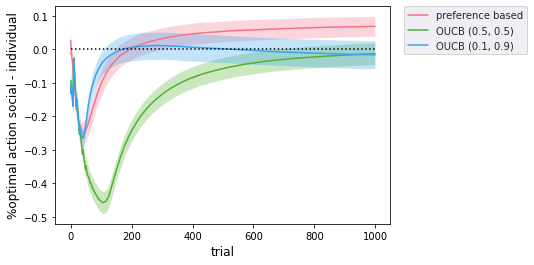

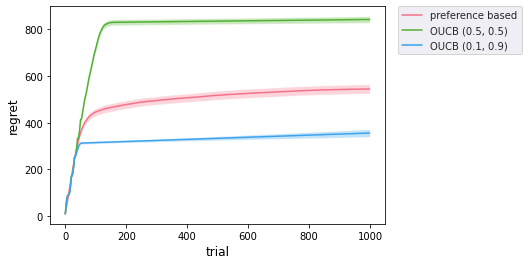

In [ ]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm100random.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm100randomR.npy')
tools().save(result,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm100random.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm100randomR.pdf', label = "regret")

In [ ]:
resultindividual = {}
resultsocial = {}
resultdifference = {}
epoch = +30
k = 100
rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)

In [ ]:
result = {}
resultR = {}
resultRc = {}
thompson_agent = 1
percent_agents = 0
p = [0.01]
increase = [0.005]
limit = [0.9]
worst_agents = 0
random_agents = 100

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [ ]:
data = sl.compare()
result["preference based"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["preference based"] = np.array(data["regret"]["social"])

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.5, beta2 = 0.5)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.5, 0.5)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.5, 0.5)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.1, beta2 = 0.9)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.1, 0.9)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.1, 0.9)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


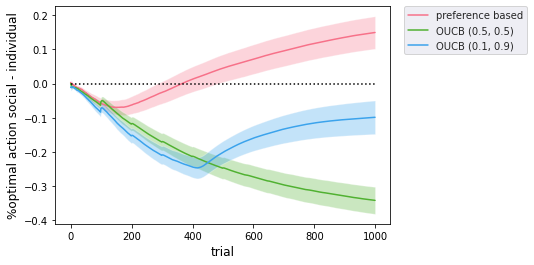

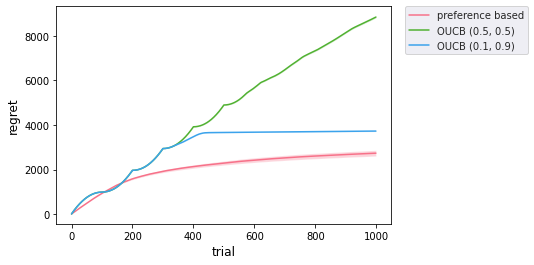

In [ ]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_100arm100random.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/comparetargerucb1learner_100arm100randomR.npy')
tools().save(result,'./gdrive/MyDrive/logt/comparetargerucb1learner_100arm100random.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_100arm100randomR.pdf', label = "regret")